In [1]:
from collections import Counter
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Circle
from mtcnn.mtcnn import MTCNN
from tqdm import tqdm
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input

Using TensorFlow backend.


In [2]:
import tensorflow as tf
# dir(tf.keras.applications)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
        print(e)

In [5]:
# 전처리 함수
def preprocess(detector, img, face_shape, file=None):
    # 얼굴 크롭
    faces = detector.detect_faces(img)
    if len(faces) != 1 :  # detect된 얼굴이 1개가 아닌 경우, 해당 데이터는 처리하지 않는다.
        return None
    
    x, y, w, h = faces[0]['box']
    
    if w < 10 or h < 10:  # detect 된 얼굴 pixel이 너무 작으면, 크롭하지 않는다.
        print('face does not exists', faces[0]['box'], file)
    else:
        # detect된 좌표를 보정한다.
        if x < 0 :
            w += x
            x = 0
        if y < 0 :
            h += y
            y = 0    
        
        # detect 패치의 중심좌표를 기준으로 정사각형으로 크롭한다.
        center_x = x + int(w/2)
        center_y = y + int(h/2)
        margin = max(w, h)
        x = center_x - int(margin/2)
        y = center_y - int(margin/2)
        if x < 0 :
            x = 0
        if y < 0 :
            y = 0  

        img = img[y:y+margin, x:x+margin, :]

    (h, w, _) = img.shape
    if h > w:
        # target shape에 행을 기준으로 맞추기
        new_w = int(w/h*face_shape[0])
        new_h = int(face_shape[0])
    else:
        # target shape에 열을 기준으로 맞추기
        new_w = int(face_shape[1])
        new_h = int(h/w*face_shape[1])
        
    try:
        img = cv2.resize(img, (new_w, new_h))    
    except Exception as e:
        msg = 'None ==>' +  file +' '+ str(img.shape) + ' ' + str(new_w) + ' ' + str(new_h) + ' ' + str(faces[0])
        print(msg)
        return None
    
    new_img = np.zeros(face_shape + (3, ))
    (h, w, _) = new_img.shape
    if face_shape[0] == new_h:
        new_img[:, int(w/2-new_w/2):int(w/2+new_w/2), :] = img
    else:    
        new_img[int(h/2-new_h/2):int(h/2+new_h/2):, :, :] = img
    return new_img

In [6]:
# FACE_DEFAULT_SHAPE = (128, 96)
FACE_DEFAULT_SHAPE = (224, 224)
detector = MTCNN()

train_df = pd.read_csv('./labels/train.pre.small.csv')
valid_df = pd.read_csv('./labels/valid.pre.small.csv')
test_df = pd.read_csv('./labels/test.small.csv')

# train_df = pd.read_csv('./labels/train.pre.csv')
# valid_df = pd.read_csv('./labels/valid.pre.csv')
# test_df = pd.read_csv('./labels/test.csv')

In [7]:
model = load_model('outputs/siamese.densenet169.v5.h5', compile=False)
# model = load_model('outputs/siamese.densenet169.all.v5.h5', compile=False)

inp = model.input[0]
base_model = model.layers[3]
infer_model = Model(inp, base_model(inp))
infer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
anchor (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Model)                (None, 128)               13561024  
Total params: 13,561,024
Trainable params: 13,402,624
Non-trainable params: 158,400
_________________________________________________________________


In [8]:
valid_vec_128 = np.load('outputs/valid_vec.128.npy')
# valid_vec_128 = np.load('outputs/valid_vec.all.128.npy')
valid_vec_128.shape

(134, 128)

In [9]:
train_vec_128 = np.load('outputs/train_vec.128.npy')
# train_vec_128 = np.load('outputs/train_vec.all.128.npy')
train_vec_128.shape

(1085, 128)

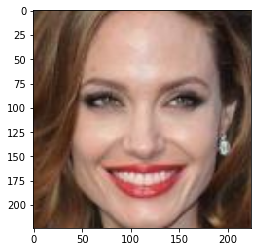

(1, 128)

In [10]:
def infer(model, detector, img_path, input_shape, is_debug=True):
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    new_img = preprocess(detector, img, input_shape)
    if type(new_img) == type(None):
        return None
    
    if is_debug:
        plt.figure()
        plt.imshow(new_img.astype('uint8'))
        plt.show()
        
    x = np.expand_dims(new_img, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    return pred

FACE_DEFAULT_SHAPE = (224, 224)
# img_path = 'test_imgs/mark_z.JPG'
# img_path = '../data/img_align_celeba/188986.jpg' # 윤아 - test
# img_path = '../data/img_align_celeba/200535.jpg' # 윤아 - train
img_path = '../data/img_align_celeba/187853.jpg' # 안젤리나 졸리 - test label 5876
# img_path = '../data/img_celeba/114190.jpg' # 

pred_128 = infer(infer_model, detector, img_path, FACE_DEFAULT_SHAPE)    
pred_128.shape

In [11]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# res = cosine_similarity(valid_vec_128, pred_128)
# res2 = euclidean_distances(valid_vec_128, pred_128)
# res3 = -np.matmul(valid_vec_128, pred_128.T)
res = cosine_similarity(train_vec_128, pred_128)
res2 = euclidean_distances(train_vec_128, pred_128)
res3 = -np.matmul(train_vec_128, pred_128.T)

np.max(res)

0.8337652825783227

In [12]:
from collections import Counter

# 임계값 이상인 데이터의 라벨별 카운트
idx, _ = np.where(res > 0.80)
cnt_dict = Counter(train_df.iloc[idx]['label'])
cnt_dict_sorted = sorted(cnt_dict.items(), key=(lambda x:x[1]), reverse=True)
cnt_dict_sorted[:5]

[(4537, 5)]

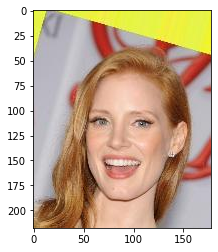

In [14]:
sample_img_name = train_df[train_df['label']==cnt_dict_sorted[0][0]]['image'].values[0]
img = image.load_img('../data/img_align_celeba/' + sample_img_name)
x = image.img_to_array(img)
plt.imshow(x.astype('uint8'))

In [13]:
# 라벨별 유사도의 평균을 구하고 제일 높은 라벨 선택
train_df['sim'] = res
df  = train_df.groupby(['label'])['sim'].mean().reset_index()
df = df.sort_values(by=['sim'], ascending=False)
df = df.reset_index()
print(df.shape)
# df[df['label']==5876]
df.head(5)

(50, 3)


,index,label,sim
0,17,4537,0.751853
1,22,5222,0.626682
2,24,5329,0.619594
3,19,4598,0.619262
4,42,8962,0.563712


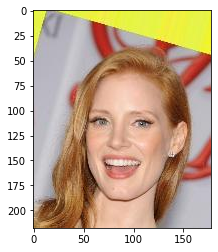

In [15]:
sample_img_name = train_df[train_df['label']==df['label'].values[0]]['image'].values[0]
img = image.load_img('../data/img_align_celeba/' + sample_img_name)
x = image.img_to_array(img)
plt.imshow(x.astype('uint8'))

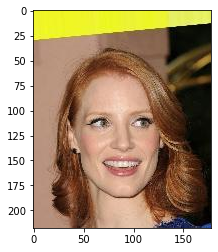

In [16]:
# 그냥 유사도가 제일 높은 이미지
sorted_similar = np.argsort(res*-1, axis=0)
sorted_similar2 = np.argsort(res2, axis=0)
sorted_similar3 = np.argsort(res3, axis=0)

img = image.load_img('../data/img_align_celeba/' + train_df.iloc[sorted_similar[0][0]][0])
# img = image.load_img('../data/img_align_celeba/' + train_df.iloc[sorted_similar2[0][0]][0])
x = image.img_to_array(img)
plt.imshow(x.astype('uint8'))

069407.jpg 130637.jpg 0.9337299073589362 5222 5222


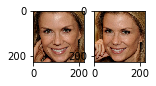

069582.jpg 140082.jpg 0.8537780836935573 8151 8151


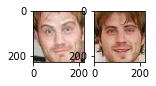

081433.jpg 007156.jpg 0.8275334902464166 4527 4527


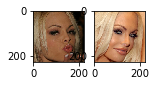

082098.jpg 129644.jpg 0.9020815659399696 4478 4478


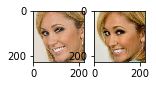

089186.jpg 150603.jpg 0.8132098095480536 975 975


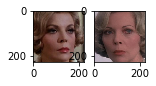

092611.jpg 146893.jpg 0.8178333421970686 8045 8045


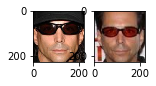

093017.jpg 147461.jpg 0.7744585990346273 1951 1951


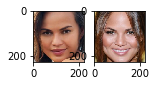

093624.jpg 153435.jpg 0.7791129481094058 4582 4582


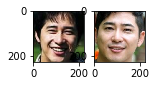

095167.jpg 131677.jpg 0.9697311536587092 3052 3052


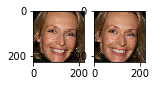

097194.jpg 130637.jpg 0.9236055807203761 5222 5222


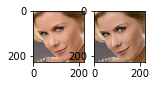

098400.jpg 131677.jpg 0.8662820447904873 3052 3052


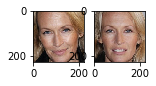

099316.jpg 115830.jpg 0.8835049726660577 2095 2095


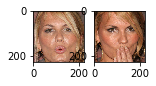

101091.jpg 130637.jpg 0.9092820835644608 5222 5222


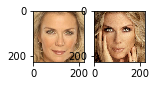

101339.jpg 132580.jpg 0.9573598555287177 4220 4220


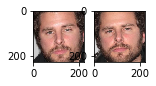

101416.jpg 147461.jpg 0.8458445183609304 1951 1951


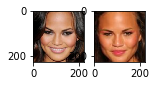

102267.jpg 123554.jpg 0.7815211182498331 9176 9176


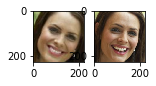

102761.jpg 146893.jpg 0.7763347215606333 8045 8045


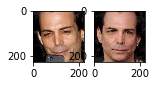

103160.jpg 140134.jpg 0.816105746191726 9297 9297


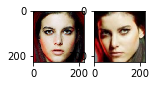

103587.jpg 149069.jpg 0.8952996757764535 5986 5986


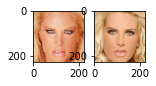

104844.jpg 150962.jpg 0.8984715770686996 9533 9533


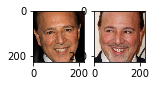

104911.jpg 149406.jpg 0.9212211050034768 2335 2335


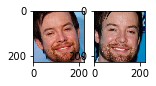

104932.jpg 017151.jpg 0.96783554645754 4070 4070


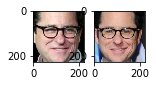

105009.jpg 141835.jpg 0.7514836480309539 5199 5199


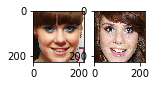

105693.jpg 142307.jpg 0.7778407711420607 9698 9698


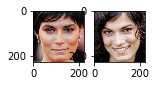

105718.jpg 007156.jpg 0.8956684227236078 4527 4527


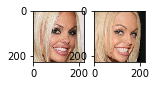

107099.jpg 154641.jpg 0.7979404226890264 4860 4860


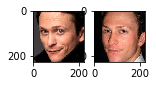

107707.jpg 146349.jpg 0.879375540372398 5329 5329


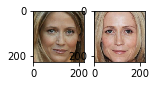

108091.jpg 150603.jpg 0.7521049247385212 975 975


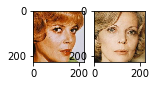

109177.jpg 135438.jpg 0.7468925733311937 4598 4598


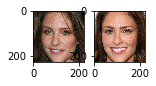

110005.jpg 132580.jpg 0.9161671606687586 4220 4220


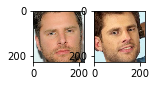

110265.jpg 126622.jpg 0.8373653023429574 10093 10093


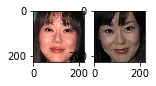

110303.jpg 153435.jpg 0.7343970568208267 4582 4582


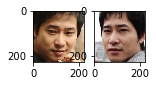

111519.jpg 146349.jpg 0.8936971409432792 5329 5329


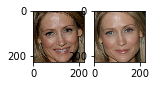

112613.jpg 149406.jpg 0.7352625028641757 2335 2335


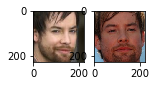

113016.jpg 150962.jpg 0.8968963994930864 9533 9533


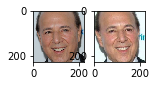

113166.jpg 133160.jpg 0.8919973157215156 3398 3398


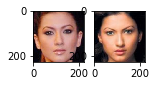

113558.jpg 149069.jpg 0.939392325055955 5986 5986


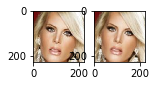

115036.jpg 140131.jpg 0.7160729404886044 6292 6292


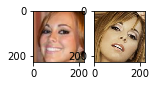

116526.jpg 144713.jpg 0.8770372288456365 8962 8962


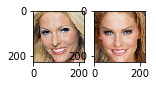

117429.jpg 145810.jpg 0.8421704143253894 8712 8712


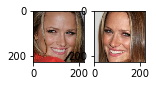

117527.jpg 017151.jpg 0.9548834435271553 4070 4070


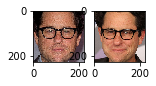

119531.jpg 150962.jpg 0.8440018950905539 9533 9533


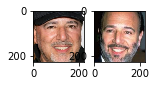

120846.jpg 156928.jpg 0.7866546750209256 7114 7114


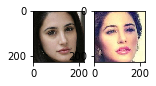

125378.jpg 144713.jpg 0.9519240741185641 8962 8962


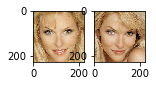

129532.jpg 149558.jpg 0.7845972882051555 2960 2960


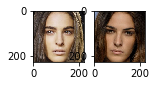

130301.jpg 144713.jpg 0.9509738796788522 8962 8962


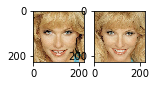

137176.jpg 150497.jpg 0.7111750652489454 8518 8518


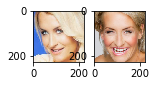

171747.jpg 178832.jpg 0.9143406239398593 1927 1927


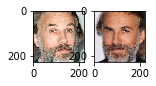

172056.jpg 179047.jpg 0.8426842388387894 4537 4537


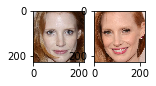

172601.jpg 179047.jpg 0.8762640597471092 4537 4537


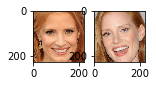

175287.jpg 181415.jpg 0.8703603882603543 1321 1321


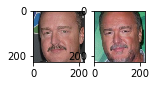

177927.jpg 181415.jpg 0.982695483775786 1321 1321


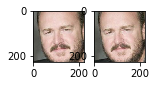

178109.jpg 167240.jpg 0.8101527712461447 1201 1201


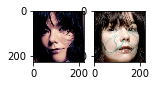

179244.jpg 181415.jpg 0.9341497075179133 1321 1321


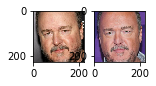

179656.jpg 181602.jpg 0.8990811667166809 3117 3117


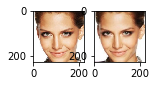

191824.jpg 197101.jpg 0.8813132646279446 7760 7760


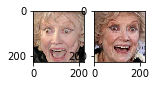

192543.jpg 200439.jpg 0.8343817058499459 6920 6920


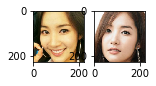

193942.jpg 199922.jpg 0.8271360773546146 7438 7438


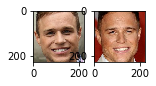

194102.jpg 200292.jpg 0.9071819159800578 8480 8480


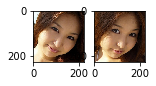

194180.jpg 200439.jpg 0.7938573758087082 6920 6920


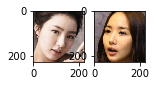

194212.jpg 197101.jpg 0.8535868391512667 7760 7760


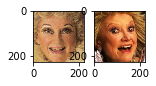

194956.jpg 199657.jpg 0.8465399190274556 8241 8241


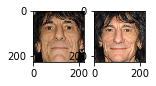

194997.jpg 197101.jpg 0.8651419969460139 7760 7760


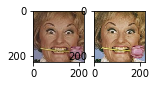

195009.jpg 185722.jpg 0.7666905638874499 7439 7439


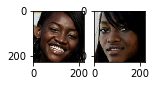

195644.jpg 199148.jpg 0.8222591553429888 5876 5876


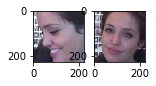

196026.jpg 200653.jpg 0.7851940736727182 8822 8822


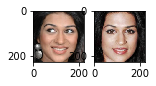

196053.jpg 200535.jpg 0.850402339242848 10062 10062


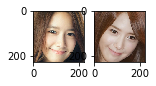

196367.jpg 200909.jpg 0.7468895662399608 5253 5253


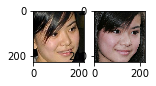

196415.jpg 185722.jpg 0.8086528761705767 7439 7439


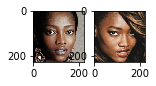

In [17]:
import glob
import tqdm
import os
from collections import Counter

data_df = pd.read_csv('identity_CelebA.txt', sep=" ", header=None)
data_df.columns = ["image", "label"]
thresh=0.0

def get_label(data_df, img_path):
    img_name = os.path.basename(img_path)
    _df = data_df[data_df['image']==img_name]
    if _df.shape[0] == 0:
        return None
    return _df['label'].values[0]
    
report_list = []
for query_img in sorted(valid_df['image'].values):
    query_img_path = os.path.join('../data/img_celeba', query_img)
    pred_128 = infer(infer_model, detector, query_img_path, FACE_DEFAULT_SHAPE, is_debug=False)    
    if type(pred_128) == type(None):
        continue
    res = cosine_similarity(train_vec_128, pred_128)
    sorted_similar = np.argsort(res*-1, axis=0)
    if np.max(res) < thresh: 
        continue
    
#     idx, _ = np.where(res > thresh)
#     cnt_dict = Counter(train_df.iloc[idx]['label'])  # 라벨카운트.
#     cnt_dict_sorted = sorted(cnt_dict.items(), key=(lambda x:x[1]), reverse=True)
#     sim_label = cnt_dict_sorted[0][0]
    
    train_df['sim'] = res
    df  = train_df.groupby(['label'])['sim'].mean().reset_index()
    df = df.sort_values(by=['sim'], ascending=False)
    df = df.reset_index()
    sim_label = df['label'].values[0]
    
    sim_list = list(res[train_df[train_df['label']==sim_label].index].reshape(-1))
    sim_img_list = train_df[train_df['label']==sim_label]['image'].values.tolist()
    
    query_img_label = get_label(data_df, query_img)
    
    max_sim = 0
    max_sim_img = ''
    for _sim, _sim_img in zip(sim_list, sim_img_list):
        report = {}
        report['query'] = query_img
        report['sim'] = _sim_img
        report['query_label'] = query_img_label
        report['sim_label'] = sim_label
        report['sim_value'] = _sim
        report_list.append(report)
        if _sim > max_sim:
            max_sim = _sim
            max_sim_img = _sim_img
            
    if query_img_label != sim_label:
        continue
        
    sample_sim_img_path = os.path.join('../data/img_celeba', max_sim_img)
    print(query_img, sim_img_list[0], max_sim, query_img_label, sim_label)
    fig = plt.figure(figsize=(2,2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    img = image.load_img(query_img_path)
    img = image.img_to_array(img)
    img = preprocess(detector, img, FACE_DEFAULT_SHAPE)
    if type(img)!=type(None):
        ax1.imshow(img.astype('uint8'))
    
    img = image.load_img(sample_sim_img_path)
    img = image.img_to_array(img)
    img = preprocess(detector, img, FACE_DEFAULT_SHAPE)
    if type(img)!=type(None):
        ax2.imshow(img.astype('uint8'))
    plt.show()    
    
report_df = pd.DataFrame(report_list)

In [18]:
report_df.to_csv('outputs/report.train.valid.small.csv', index=False)

In [19]:
print(report_df.shape)
print(report_df[report_df['query_label']==report_df['sim_label']].shape)

(2929, 5)
(1504, 5)


In [122]:
# len(set(df_test['label']))

In [123]:
# df_test.shape

In [120]:
# df_train[df_train['label']==10062]

In [119]:
# celeb_data.shape

In [118]:
# len(set(train_df['label'])), len(set(valid_df['label'])), len(set(test_df['label']))

In [117]:
# test_df.shape

../data/img_celeba_valid\1023.126354.jpg ../data/img_celeba\151789.jpg 0.99112222422817 1023 1023


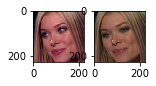

../data/img_celeba_valid\1066.124986.jpg ../data/img_celeba\154007.jpg 0.9690277037665643 1066 1066


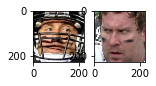

../data/img_celeba_valid\1135.102731.jpg ../data/img_celeba\139756.jpg 0.9728279904143788 1135 1135


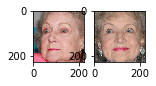

../data/img_celeba_valid\1188.175050.jpg ../data/img_celeba\179251.jpg 0.9546281379998597 1188 1188


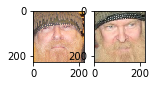

../data/img_celeba_valid\1264.072846.jpg ../data/img_celeba\134905.jpg 0.9769869776903417 1264 1264


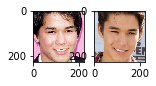

../data/img_celeba_valid\1264.112387.jpg ../data/img_celeba\134905.jpg 0.9865043091991474 1264 1264


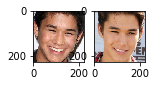

../data/img_celeba_valid\1498.174437.jpg ../data/img_celeba\182073.jpg 0.9829309023456667 1498 1498


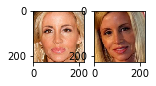

../data/img_celeba_valid\1657.101288.jpg ../data/img_celeba\138467.jpg 0.9804425421915902 1657 1657


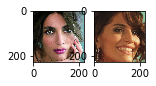

../data/img_celeba_valid\1784.130542.jpg ../data/img_celeba\159053.jpg 0.9908533506323556 1784 1784


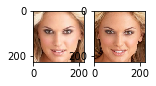

../data/img_celeba_valid\1882.174755.jpg ../data/img_celeba\180354.jpg 0.9696243027702969 1882 1882


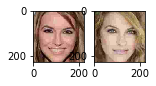

../data/img_celeba_valid\1882.175656.jpg ../data/img_celeba\180354.jpg 0.9743290728600862 1882 1882


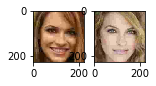

../data/img_celeba_valid\1938.125046.jpg ../data/img_celeba\143085.jpg 0.9713650226173732 1938 1938


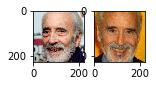

../data/img_celeba_valid\2078.127451.jpg ../data/img_celeba\147802.jpg 0.9983968583535785 2078 2078


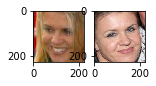

../data/img_celeba_valid\2167.173124.jpg ../data/img_celeba\180325.jpg 0.9742338239657562 2167 2167


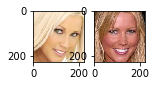

../data/img_celeba_valid\2761.122578.jpg ../data/img_celeba\149663.jpg 0.9824511079284988 2761 2761


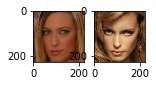

../data/img_celeba_valid\2879.100684.jpg ../data/img_celeba\137834.jpg 0.9920232479145641 2879 2879


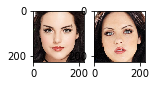

../data/img_celeba_valid\3080.108251.jpg ../data/img_celeba\150174.jpg 0.9842527035732606 3080 3080


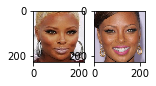

../data/img_celeba_valid\3436.092715.jpg ../data/img_celeba\133697.jpg 0.9957621959089582 3436 3436


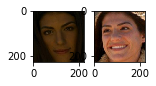

../data/img_celeba_valid\3648.118018.jpg ../data/img_celeba\136332.jpg 0.9853244858407146 3648 3648


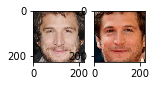

../data/img_celeba_valid\3706.084020.jpg ../data/img_celeba\141192.jpg 0.9811528487367823 3706 3706


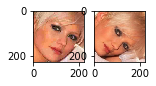

../data/img_celeba_valid\3762.102135.jpg ../data/img_celeba\138941.jpg 0.9769831022264337 3762 3762


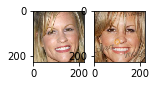

../data/img_celeba_valid\3788.104602.jpg ../data/img_celeba\149685.jpg 0.9803783469024185 3788 3788


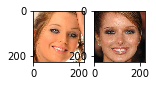

../data/img_celeba_valid\394.085838.jpg ../data/img_celeba\139068.jpg 0.9846220437001111 394 394


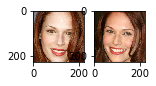

../data/img_celeba_valid\4027.096493.jpg ../data/img_celeba\133116.jpg 0.9799240930981507 4027 4027


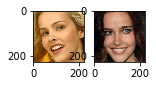

../data/img_celeba_valid\4030.173367.jpg ../data/img_celeba\179968.jpg 0.9880036971971573 4030 4030


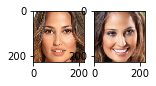

../data/img_celeba_valid\4114.116302.jpg ../data/img_celeba\144762.jpg 0.9784130931906848 4114 4114


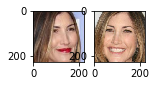

../data/img_celeba_valid\4168.073987.jpg ../data/img_celeba\131801.jpg 0.979055786841224 4168 4168


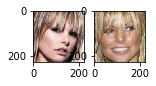

../data/img_celeba_valid\4236.117464.jpg ../data/img_celeba\142373.jpg 0.9945339691549392 4236 4236


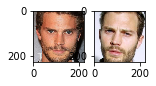

../data/img_celeba_valid\4302.170844.jpg ../data/img_celeba\178619.jpg 0.9862640539813112 4302 4302


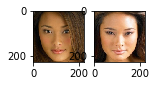

../data/img_celeba_valid\447.085936.jpg ../data/img_celeba\131461.jpg 0.9817070737158182 447 447


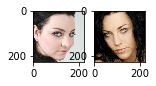

../data/img_celeba_valid\447.094414.jpg ../data/img_celeba\131461.jpg 0.9771108785487639 447 447


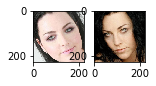

../data/img_celeba_valid\4474.173463.jpg ../data/img_celeba\179129.jpg 0.9811916920548017 4474 4474


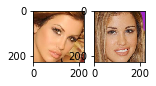

../data/img_celeba_valid\4516.177768.jpg ../data/img_celeba\181096.jpg 0.9851727957624341 4516 4516


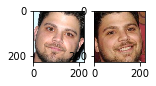

../data/img_celeba_valid\4650.107252.jpg ../data/img_celeba\140441.jpg 0.9637597196295524 4650 4650


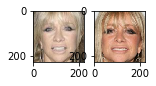

../data/img_celeba_valid\4696.175332.jpg ../data/img_celeba\180799.jpg 0.9738466551535704 4696 4696


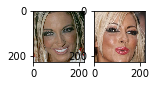

../data/img_celeba_valid\5035.195545.jpg ../data/img_celeba\185528.jpg 0.9653310406776727 5035 5035


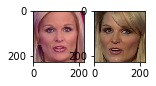

../data/img_celeba_valid\5035.197615.jpg ../data/img_celeba\185528.jpg 0.9930775575436692 5035 5035


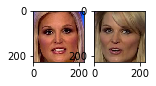

../data/img_celeba_valid\5120.112429.jpg ../data/img_celeba\143392.jpg 0.9849431100540488 5120 5120


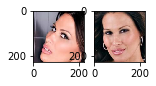

../data/img_celeba_valid\5122.098845.jpg ../data/img_celeba\139783.jpg 0.9874757505600389 5122 5122


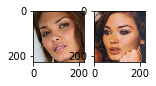

../data/img_celeba_valid\5238.119961.jpg ../data/img_celeba\146545.jpg 0.9526022773971536 5238 5238


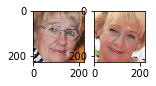

../data/img_celeba_valid\5247.072343.jpg ../data/img_celeba\118530.jpg 0.9908063716628036 5247 5247


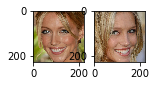

../data/img_celeba_valid\5247.083008.jpg ../data/img_celeba\118530.jpg 0.9778800398911959 5247 5247


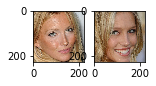

../data/img_celeba_valid\5301.195660.jpg ../data/img_celeba\200214.jpg 0.979761821185986 5301 5301


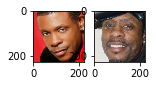

../data/img_celeba_valid\5341.128527.jpg ../data/img_celeba\155673.jpg 0.9878318614384177 5341 5341


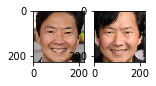

../data/img_celeba_valid\5428.106267.jpg ../data/img_celeba\149932.jpg 0.9774407910542955 5428 5428


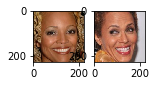

../data/img_celeba_valid\56.176490.jpg ../data/img_celeba\180860.jpg 0.9834121086955062 56 56


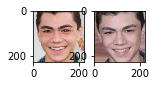

../data/img_celeba_valid\5620.195883.jpg ../data/img_celeba\199995.jpg 0.9896845953344903 5620 5620


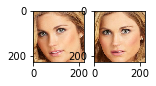

../data/img_celeba_valid\567.113889.jpg ../data/img_celeba\151772.jpg 0.9859256776177422 567 567


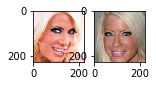

../data/img_celeba_valid\600.091255.jpg ../data/img_celeba\120107.jpg 0.978720775538244 600 600


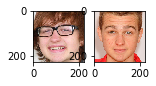

../data/img_celeba_valid\6058.108520.jpg ../data/img_celeba\149182.jpg 0.9818451344511687 6058 6058


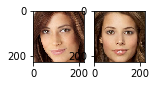

../data/img_celeba_valid\6204.105428.jpg ../data/img_celeba\150155.jpg 0.9859775480540064 6204 6204


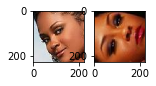

../data/img_celeba_valid\6204.108912.jpg ../data/img_celeba\150155.jpg 0.9910636327426428 6204 6204


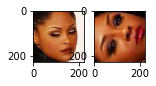

../data/img_celeba_valid\6214.113185.jpg ../data/img_celeba\135357.jpg 0.9829836394396702 6214 6214


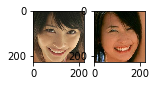

../data/img_celeba_valid\6286.080529.jpg ../data/img_celeba\113757.jpg 0.9693589930957937 6286 6286


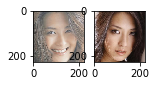

../data/img_celeba_valid\6325.095816.jpg ../data/img_celeba\133269.jpg 0.9855854266350788 6325 6325


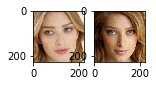

../data/img_celeba_valid\6407.198501.jpg ../data/img_celeba\184221.jpg 0.9980111626115482 6407 6407


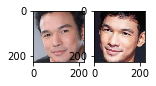

../data/img_celeba_valid\6695.096368.jpg ../data/img_celeba\143846.jpg 0.9774398168420693 6695 6695


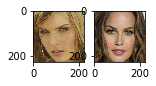

../data/img_celeba_valid\6695.123396.jpg ../data/img_celeba\143846.jpg 0.9795208217326224 6695 6695


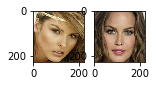

../data/img_celeba_valid\6792.119008.jpg ../data/img_celeba\148367.jpg 0.9817154728882559 6792 6792


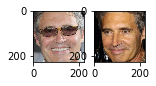

../data/img_celeba_valid\6809.193923.jpg ../data/img_celeba\198739.jpg 0.9822787530835206 6809 6809


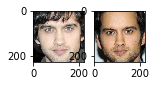

../data/img_celeba_valid\7002.193375.jpg ../data/img_celeba\199045.jpg 0.9866642156811141 7002 7002


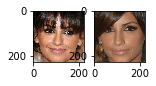

../data/img_celeba_valid\7286.106612.jpg ../data/img_celeba\013051.jpg 0.9819999105622909 7286 7286


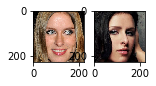

../data/img_celeba_valid\7743.101295.jpg ../data/img_celeba\139083.jpg 0.9967607749872737 7743 7743


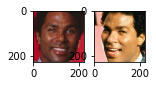

../data/img_celeba_valid\7743.116769.jpg ../data/img_celeba\139083.jpg 0.9994229468935456 7743 7743


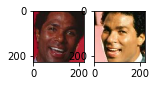

../data/img_celeba_valid\8460.093264.jpg ../data/img_celeba\154722.jpg 0.9860549264735441 8460 8460


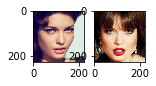

../data/img_celeba_valid\8597.127840.jpg ../data/img_celeba\155206.jpg 0.9735388485838333 8597 8597


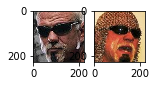

../data/img_celeba_valid\8597.128552.jpg ../data/img_celeba\155206.jpg 0.9814636641692527 8597 8597


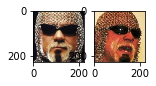

../data/img_celeba_valid\8602.111475.jpg ../data/img_celeba\143149.jpg 0.9980914865159611 8602 8602


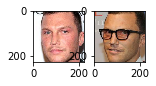

../data/img_celeba_valid\871.118254.jpg ../data/img_celeba\147963.jpg 0.9859602292292662 871 871


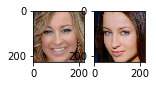

../data/img_celeba_valid\8715.194070.jpg ../data/img_celeba\201235.jpg 0.987631413608811 8715 8715


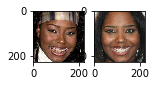

../data/img_celeba_valid\8771.195300.jpg ../data/img_celeba\198714.jpg 0.9679691696122509 8771 8771


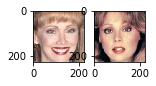

../data/img_celeba_valid\9177.109956.jpg ../data/img_celeba\137324.jpg 0.9965350755066881 9177 9177


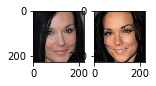

../data/img_celeba_valid\9179.102867.jpg ../data/img_celeba\141509.jpg 0.9891268444351793 9179 9179


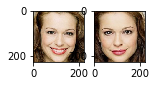

../data/img_celeba_valid\953.176356.jpg ../data/img_celeba\180088.jpg 0.9869057777676365 953 953


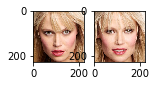

../data/img_celeba_valid\9944.093596.jpg ../data/img_celeba\138378.jpg 0.9801135141470266 9944 9944


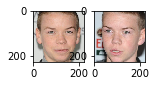

In [38]:
import glob
import tqdm
import os
from collections import Counter

data_df = pd.read_csv('identity_CelebA.txt', sep=" ", header=None)
data_df.columns = ["image", "label"]
thresh=0.95

def get_label(data_df, img_path):
    img_name = os.path.basename(img_path)
    _df = data_df[data_df['image']==img_name]
    if _df.shape[0] == 0:
        return None
    return _df['label'].values[0]
    
# for query_img_path in tqdm.tqdm(sorted(list(glob.glob('../data/img_celeba_valid/*.jpg')))):
report_list = []
#for query_img_path in sorted(list(glob.glob('../data/img_celeba_valid/*.jpg'))):
for img_path in sorted(valid_df['image'].values):
    query_img_path = os.path.join('../data/img_celeba', img_path)
    pred_128 = infer(infer_model, detector, query_img_path, FACE_DEFAULT_SHAPE, is_debug=False)    
    if type(pred_128) == type(None):
        continue
    res = cosine_similarity(train_vec_128, pred_128)
    sorted_similar = np.argsort(res*-1, axis=0)
    if np.max(res) < thresh: 
        continue
    
    idx, _ = np.where(res > thresh)
    cnt_dict = Counter(train_df.iloc[idx]['label'])  # 라벨카운트.
    cnt_dict_sorted = sorted(cnt_dict.items(), key=(lambda x:x[1]), reverse=True)
    sim_label = cnt_dict_sorted[0][0]
    sim_list = list(res[train_df[train_df['label']==sim_label].index].reshape(-1))
    sim_img_list = train_df[train_df['label']==sim_label]['image'].values.tolist()
    
    _query_img_path = os.path.basename(query_img_path)
    _query_img_path = _query_img_path.split('.')
    _query_img_path = _query_img_path[1:]
    _query_img_path = ".".join(_query_img_path)
    query_img_label = get_label(data_df, _query_img_path)
    
    for _sim, _sim_img in zip(sim_list, sim_img_list):
        report = {}
        report['query'] = _query_img_path
        report['sim'] = _sim_img
        report['query_label'] = query_img_label
        report['sim_label'] = sim_label
        report['sim_value'] = _sim
        report_list.append(report)
        
    if query_img_label != sim_label:
        continue
        
    sample_sim_img_path = os.path.join('../data/img_celeba', sim_img_list[0])
    print(query_img_path, sample_sim_img_path, np.max(res), query_img_label, sim_label)
    fig = plt.figure(figsize=(2,2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    
    img = image.load_img(query_img_path)
    img = image.img_to_array(img)
    img = preprocess(detector, img, FACE_DEFAULT_SHAPE)
    if type(img)!=type(None):
        ax1.imshow(img.astype('uint8'))
    
    img = image.load_img(sample_sim_img_path)
    img = image.img_to_array(img)
    img = preprocess(detector, img, FACE_DEFAULT_SHAPE)
    if type(img)!=type(None):
        ax2.imshow(img.astype('uint8'))
    plt.show()    
    
report_df = pd.DataFrame(report_list)

In [42]:
report_df.to_csv('train.valid.report.95.csv', index=False)

In [116]:
# test_df

In [33]:
# test_df[test_df['label']==10062]

In [34]:
# valid_df[valid_df['label']==10062]